In [1]:
import scvelo as scv
import scanpy as sc
import numpy as np
import sklearn
import scipy
import pandas as pd
import seaborn as sns
import pickle
import os
import sys
import anndata as ad
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


SEED = 2024
np.random.seed(SEED)

2024-05-29 14:18:31.654974: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-29 14:18:31.655005: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
adata = sc.read_h5ad("/media/liyaru/LYR/Diff_change/8_dynamo_Data/scNT_HSC_scvelo_process.h5ad")
print(adata)
scv.tl.velocity(adata, mode='stochastic')
print(adata)
adata_raw = adata.copy()

AnnData object with n_obs × n_vars = 1947 × 2000
    obs: 'batch', 'cell_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'gene_name_mapping', 'query', 'scopes', '_id', '_score', 'symbol', 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'PCs', 'batch_colors', 'cell_type_colors', 'dynamics', 'explained_variance_ratio_', 'feature_selection', 'genes_to_use', 'grid_velocity_umap', 'neighbors', 'pca_mean', 'pp', 'velocyto_SVR'
    obsm: 'X_pca', 'X_umap', 'scNT_velocity_umap', 'velocity_umap'
    layers: 'M_n', 'M_nn', 'M_s', 'M_ss', 'M_t', 'M_tn', 'M_tt', 'M_u', 'M_us', 'M_uu',

In [3]:
adata.var["velocity_genes"] = True

# Add noise to data
X = np.tile(adata_raw.X.A[:, adata.var["velocity_genes"]], (5, 1))
Y = np.tile(adata.layers["velocity"][:, adata.var["velocity_genes"]], (5, 1))
noise_sigma = (adata_raw.X.A.std()/70)**2
X[adata_raw.shape[0]:, :] += \
    np.random.normal(0, noise_sigma, X[adata_raw.shape[0]:, :].shape)

XYpath = "DeepVelo_SA_prepropcessed.npz"
np.savez(XYpath, X, Y)

X = np.load(XYpath)["arr_0"]
Y = np.load(XYpath)["arr_1"]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, 
                                                    Y, 
                                                    test_size=0.1, 
                                                    random_state=42)



#from vae import create_encoder, create_decoder, VAE
tf.config.list_physical_devices('GPU') 


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


"""
## Build the encoder
"""

def create_encoder(input_size = 1000, latent_dim = 16, verbose=1):
    encoder_inputs = keras.Input(shape=(input_size,))
    x = layers.Dense(64, activation="relu", activity_regularizer=keras.regularizers.l1(1e-6))(encoder_inputs)
    z_mean = layers.Dense(latent_dim, name="z_mean", activity_regularizer=keras.regularizers.l1(1e-6))(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var", activity_regularizer=keras.regularizers.l1(1e-6))(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    if verbose == 1:
        encoder.summary()
    return encoder

"""
## Build the decoder
"""

def create_decoder(output_size = 1000, latent_dim = 16, verbose=1):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(16, activation="relu", activity_regularizer=keras.regularizers.l1(1e-6))(latent_inputs)
    x = layers.Dense(64, activation="relu", activity_regularizer=keras.regularizers.l1(1e-6))(x)
    decoder_outputs = layers.Dense(output_size)(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    if verbose == 1:
        decoder.summary()
    return decoder

"""
## Define the VAE as a `Model` with a custom `train_step`
"""


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                    keras.losses.MSE(y, reconstruction)
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction
    
    def test_step(self, data):
        x, y = data
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            keras.losses.MSE(y, reconstruction)
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


encoder = create_encoder(X.shape[1])
decoder = create_decoder(X.shape[1])

autoencoder = VAE(encoder, decoder)
opt = keras.optimizers.Adam(learning_rate=0.00001)
autoencoder.compile(optimizer=opt)

autoencoder.fit(X_train, y_train,
        epochs=100,
        batch_size=10,
        shuffle=True,
        validation_data=(X_test, y_test))


2024-05-29 14:18:47.371101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-29 14:18:47.371265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-05-29 14:18:47.371381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-05-29 14:18:47.404248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2024-05-29 14:18:47.404436: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835]

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2000)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           128064      input_1[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 16)           1040        dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 16)           1040        dense[0][0]                      
____________________________________________________________________________________________

2024-05-29 14:18:49.128478: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
877/877 [==============================] - 4s 3ms/step - loss: 0.7970 - reconstruction_loss: 0.0369 - kl_loss: 0.5032 - val_loss: 0.4362 - val_reconstruction_loss: 0.0369 - val_kl_loss: 0.3992
Epoch 2/100
877/877 [==============================] - 2s 2ms/step - loss: 0.1965 - reconstruction_loss: 0.0335 - kl_loss: 0.1235 - val_loss: 0.1254 - val_reconstruction_loss: 0.0350 - val_kl_loss: 0.0903
Epoch 3/100
877/877 [==============================] - 2s 2ms/step - loss: 0.0812 - reconstruction_loss: 0.0314 - kl_loss: 0.0389 - val_loss: 0.0533 - val_reconstruction_loss: 0.0325 - val_kl_loss: 0.0208
Epoch 4/100
877/877 [==============================] - 2s 3ms/step - loss: 0.0484 - reconstruction_loss: 0.0294 - kl_loss: 0.0161 - val_loss: 0.0372 - val_reconstruction_loss: 0.0307 - val_kl_loss: 0.0065
Epoch 5/100
877/877 [==============================] - 2s 2ms/step - loss: 0.0377 - reconstruction_loss: 0.0273 - kl_loss: 0.0080 - val_loss: 0.0310 - val_reconstruction_loss: 0.02

In [4]:
X = adata_raw.X.A[:, adata.var["velocity_genes"]]
velocity_deepvelo = autoencoder.predict(X)
print(velocity_deepvelo.shape)
adata.layers['velocity_dv'] = velocity_deepvelo

(1947, 2000)


        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 10/20 cores)


  0%|          | 0/1947 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'velocity_dv_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dv_umap', embedded velocity vectors (adata.obsm)
saving figure to file Figure/stream/deepvelo_SA.svg


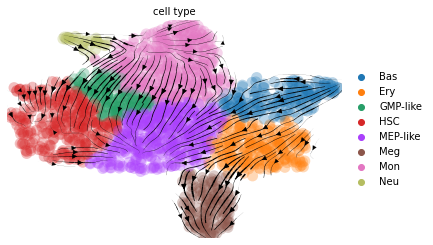

In [5]:
scv.tl.velocity_graph(adata,vkey="velocity_dv",n_jobs=10,basis= "umap")
scv.pl.velocity_embedding_stream(adata,basis= "umap",color="cell_type",
                                 vkey="velocity_dv",
                                 palette = sc.pl.palettes.default_20,
                                 legend_loc = 'right margin',
                                 save="Figure/stream/" + "deepvelo_SA.svg" )

In [6]:
adata.write_h5ad("adata/deepveloSA.h5ad")